In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
matplotlib.rc('axes', titlesize=12)
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### 0- Loading the Data

In [2]:
transactions1 = pd.read_csv("transactions_1.csv", index_col='Unnamed: 0')
transactions2 = pd.read_csv("transactions_2.csv", index_col='Unnamed: 0')
transactions = pd.concat([transactions1, transactions2])

In [3]:
transactions

,customer_id,product_id,date
0,6689489,0A4G5LZWCP,2017-01-31T09:31:08.873Z
1,6689489,XZ6UVEYK40,2017-02-03T16:59:16.610Z
2,6689489,XZ6UVEYK40,2017-02-05T19:47:55.353Z
3,6689489,XZ6UVEYK40,2017-02-05T19:48:14.633Z
4,6689489,XZ6UVEYK40,2017-02-06T09:59:49.053Z
...,...,...,...
975950,9770266,5RPSDK28JR,2019-05-17T10:06:43.037Z
975951,2552305,5RPSDK28JR,2017-10-27T17:49:54.483Z
975952,6004163,I2IYFZIO6X,2019-01-09T16:31:08.133Z
975953,6632569,0A4G5LZWCP,2017-03-29T16:25:05.907Z


#### 0-1 Extracting year and month from the date column

In [4]:
transactions['year'] = pd.DatetimeIndex(transactions['date']).year
transactions['month'] = pd.DatetimeIndex(transactions['date']).month
transactions

,customer_id,product_id,date,year,month
0,6689489,0A4G5LZWCP,2017-01-31T09:31:08.873Z,2017,1
1,6689489,XZ6UVEYK40,2017-02-03T16:59:16.610Z,2017,2
2,6689489,XZ6UVEYK40,2017-02-05T19:47:55.353Z,2017,2
3,6689489,XZ6UVEYK40,2017-02-05T19:48:14.633Z,2017,2
4,6689489,XZ6UVEYK40,2017-02-06T09:59:49.053Z,2017,2
...,...,...,...,...,...
975950,9770266,5RPSDK28JR,2019-05-17T10:06:43.037Z,2019,5
975951,2552305,5RPSDK28JR,2017-10-27T17:49:54.483Z,2017,10
975952,6004163,I2IYFZIO6X,2019-01-09T16:31:08.133Z,2019,1
975953,6632569,0A4G5LZWCP,2017-03-29T16:25:05.907Z,2017,3


### 2- Basic Questions
### 2-1 Create an ordered (descending) plot for the total number of transactions per customer from the most to the least active customer.

In [5]:
transaction_per_customer = transactions.groupby('customer_id').size()
sorted_trans_per_customer = transaction_per_customer.sort_values(ascending=False)
sorted_trans_per_customer

customer_id
6689489    34963
5381109    33355
1756454    18927
4435859    13450
8350659    10490
           ...  
8964627        1
7695751        1
4877229        1
7742978        1
1646090        1
Length: 2002, dtype: int64

Text(0.5, 1.0, 'sorted number of transactions per customer')

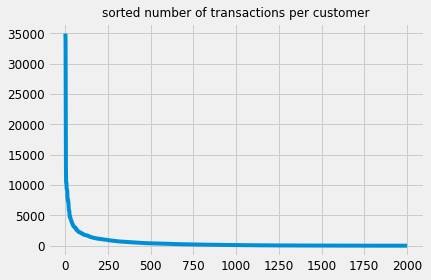

In [6]:
x = sorted_trans_per_customer.reset_index(drop=True)
plt.plot(x)
plt.title('sorted number of transactions per customer')

#### 1-2 Given any product ID, create a plot to show its transaction frequency per month for the year 2018.

In [7]:
def plot_trans_perMonth(productID, year):
    year_filtered_df = transactions[transactions['year'] == year]
    monthly_bill = year_filtered_df.groupby(['product_id', 'month']).size()
    plt.plot(monthly_bill[productID])
    plt.xlabel('month')
    plt.ylabel('# of transactions') 
    plt.title('monthly trancations of '+ productID + ' in ' + str(year))

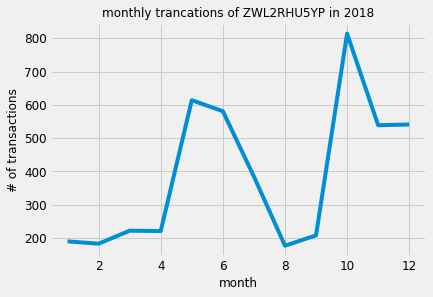

In [8]:
plot_trans_perMonth('ZWL2RHU5YP', 2018)

### 3- At any time, what are the top 5 products that drove the highest sales over the last six months?

In [9]:
def get_last_n_month_highest_sale(n, current_year, current_month):
    tmp_transactions = transactions.copy()
    
    min_year = tmp_transactions['year'].min()
    # create a column of 'number of passed months until now to ease the calculations of past n month transaction history'
    tmp_transactions['acc_month'] = (tmp_transactions['year'] - min_year)*12 + tmp_transactions['month']
    current_acc_month = (current_year - min_year)*12 + current_month
    min_acc_month = (current_year - min_year)*12 + current_month - n + 1
    
    filtered = tmp_transactions[(tmp_transactions['acc_month'] >= min_acc_month)&(tmp_transactions['acc_month']<= current_acc_month)]
    return filtered.groupby('product_id').size().sort_values(ascending=False).head(5)

In [10]:
get_last_n_month_highest_sale(6, 2019, 8)

product_id
5RPSDK28JR    21745
XZ6UVEYK40    10423
VD51ZQPY9D    10204
XD4I34ED7F     9585
G5HEPH9A2T     9267
dtype: int64

### 4- Build a model to predict the total number of expected transactions over the next month for any customer. Split your data appropriately and give enough validation for the performance of your model by simulating the predicted results and comparing with the true values or however you see fit. Keep in mind that sometimes a carefully crafted plot is worth a thousand words.

#### Obviously, this is a time series prediction ML problem (which is new to me), and we are dealing with the concept of time, so I search around the internet and found  these links ([1](https://towardsdatascience.com/time-series-machine-learning-regression-framework-9ea33929009a), [2](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b), and [3](https://www.pluralsight.com/guides/machine-learning-for-time-series-data-in-python)) very helpful and used them to solve this problem.

#### 4-1. Create a proper dataframe which shows us the monthly transactions of each product

In [11]:
def create_monthly_sale_df():
    monthly_trans_df = transactions.copy()
    min_year = monthly_trans_df['year'].min()
    monthly_trans_df['acc_month'] = (monthly_trans_df['year'] - min_year)*12 + monthly_trans_df['month']
    max_month = monthly_trans_df['acc_month'].max()
    monthly_trans_df = monthly_trans_df.drop(columns=['date', 'year', 'month'])
    monthly_trans_df = monthly_trans_df.groupby(['product_id', 'acc_month']).size().to_frame(name = 'count')
    
    monthly_trans_df = monthly_trans_df.pivot_table('count', 'product_id', 'acc_month').fillna(0)
    monthly_trans_df = monthly_trans_df.reset_index().melt(id_vars='product_id', var_name='month', value_name='sales')
    return monthly_trans_df
    

In [12]:
monthly_trans = create_monthly_sale_df()
monthly_trans

,product_id,month,sales
0,0A4G5LZWCP,1,844.0
1,0AB7PTAD3X,1,18.0
2,0HLIWH0CA1,1,691.0
3,0UZVWTQ50H,1,0.0
4,0W3289OYXV,1,38.0
...,...,...,...
1945,YRRT480XIZ,39,12.0
1946,Z4N23EOA13,39,235.0
1947,Z6OHD7VB3J,39,0.0
1948,ZH8YQX1ZL2,39,0.0


#### 4-2 map product_id to an integer and keep the mapping in a dictionary for recovering

In [13]:
monthly_trans['id'] = monthly_trans.index%50 
monthly_trans['id'] = monthly_trans['id'] + 1
monthly_trans['month'] = monthly_trans['month'] - 1
product_id_mapping_dict = monthly_trans[['product_id', 'id']].to_dict('records')
monthly_trans = monthly_trans[['id', 'month', 'sales']]
monthly_trans = monthly_trans.astype('int')
monthly_trans

,id,month,sales
0,1,0,844
1,2,0,18
2,3,0,691
3,4,0,0
4,5,0,38
...,...,...,...
1945,46,38,12
1946,47,38,235
1947,48,38,0
1948,49,38,0


We can see a random product's monthy transactions over 39 months

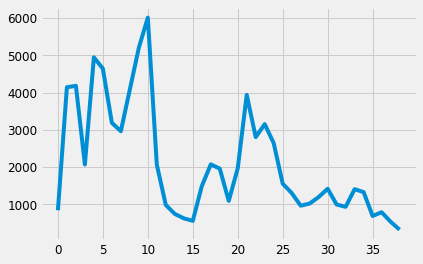

In [14]:
x = monthly_trans[monthly_trans['id'] == 1]['month']
y = monthly_trans[monthly_trans['id'] == 1]['sales']
plt.plot(x, y)

### 4-3 Now, lets try to solve the problem

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn import base

#### 4-3-1 In order to turn a time series forcasting problem to a supervised learning one, one way is to add lags of time as inputs of the ML model (number of these lags can be considered as a hyperparameter of our problem). Here, ToSupervised and ToSupervisedDiff classes prepares and shapes the data in the mentioend format. The conversion to the new data format will be conducted by a simple pipeline.

In [16]:
class ToSupervised(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col, groupCol, num_lags, dropna=False):
        self.col = col
        self.groupCol = groupCol
        self.num_lags = num_lags
        self.dropna = dropna
    
    def fit(self, X, y=None):
        self.X = X
        return self
    
    def transform(self, X):
        new_X = self.X.copy()
        for i in range(1, self.num_lags+1):
            new_X[str(i)+'_Month_Ago'+"_"+self.col] = new_X.groupby([self.groupCol])[self.col].shift(i) 
            
        if self.dropna:
            new_X = new_X.dropna()
            new_X = new_X.reset_index(drop=True)
        
        return new_X

In [17]:
class ToSupervisedDiff(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col, groupCol, num_lags, dropna=False):
        self.col = col
        self.groupCol = groupCol
        self.num_lags = num_lags
        self.dropna = dropna
    
    def fit(self, X, y=None):
        self.X = X
        return self
    
    def transform(self, X):
        new_X = self.X.copy()
        for i in range(1, self.num_lags+1):
            new_X[str(i)+'_Month_Ago_Diff_'+"_"+self.col] = new_X.groupby([self.groupCol])[self.col].diff(i) 
            
        if self.dropna:
            new_X = new_X.dropna()
            new_X = new_X.reset_index(drop=True)
        
        return new_X

### 1-2 Time-Series K-Fold

In [18]:
from itertools import chain

class Kfold_time(object):
    
    def __init__(self, **options):
        self.target = options.pop('target', None)
        self.month_col = options.pop('month_col', None)
        self.start_month = options.pop('start_month', None)
        self.end_month = options.pop('end_month', None)
        
        if options:
            raise TypeError("Invalid parameters passed: %s" % str(options))
            
        if ((self.target==None )| (self.month_col==None )| (self.start_month==None ) | (self.end_month==None )):
            raise TypeError("Incomplete inputs")
    
    def _train_test_split(self, X):
        n_arrays = len(X)
        if n_arrays == 0:
            raise ValueError("At least one array required as input")
        
        for i in range(self.start_month, self.end_month):
            train = X[X[self.month_col] < i]
            val = X[X[self.month_col] == i]
            
            X_train, X_test = train.drop([self.target], axis=1), val.drop([self.target], axis=1)
            y_train, y_test = train[self.target].values, val[self.target].values
            
            yield X_train, X_test, y_train, y_test
        
    def split(self, X):
        cv_t = self._train_test_split(X)
        return chain(cv_t)

### 1-3 Metric: RMSLE

In [19]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [20]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

#### 1-4 Baseline Estimator

In [21]:
class BaseEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self, predCol):
        """
            As a base model we assume the number of sales last week and this week are the same
            Input: 
                    predCol: l-week ago sales
        """
        self.predCol = predCol
        
    def fit(self, X, y):
        return self
    
    def predict(self, X):
        pred = X[self.predCol].values
        return pred

    def score(self, X, y, scoring):
        
        prediction = self.predict(X)
        error = scoring(y, prediction) # np.sqrt(mean_squared_log_error(y, prediction))
        return error
    

#### 1-5 Time-Series Regression

In [22]:
class TimeSeriesRegressor(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self, model, cv, scoring, verbosity=True):
        self.model = model
        self.cv = cv
        self.scoring = scoring
        self.verbosity = verbosity
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X=None):
        
        pred = {}
        for idx, fold in enumerate(self.cv.split(X)):
            
            X_train, X_test, y_train, y_test = fold
            self.model.fit(X_train, y_train)
            pred[str(idx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
        return prediction
    
    def score(self, X, y=None):
        
        errors = []
        for idx, fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            prediction = self.model.predict(X_test)
            error = self.scoring(y_test, prediction)
            errors.append(error)
            
            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(idx,error))
        if self.verbosity:
            print('Total Error {:.4f}'.format(np.mean(errors)))

        return error

        

In [23]:
class TimeSeriesRegressorLog(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,model,cv,scoring,verbosity=True):
        self.model = model
        self.cv = cv
        self.scoring = scoring
        self.verbosity = verbosity
        
            
    def fit(self,X,y=None):
        return self
        
    
    def predict(self,X=None):
        
        pred = {}
        for idx, fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            pred[str(idx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
    
        return prediction

    
    def score(self,X,y=None):

        errors = []
        for idx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, np.log1p(y_train))
            prediction = np.expm1(self.model.predict(X_test))
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(idx,error))

        if self.verbosity:
                print('Total Error {:.4f}'.format(np.mean(errors)))

        return errors

#### 1-6 Data Preparation

In [24]:
steps = [('1_step',ToSupervised('sales','id',1)),
         ('1_step_diff',ToSupervisedDiff('1_Month_Ago_sales','id',1,dropna=True))]
super_1 = Pipeline(steps).fit_transform(monthly_trans)

In [25]:
super_1

,id,month,sales,1_Month_Ago_sales,1_Month_Ago_Diff__1_Month_Ago_sales
0,1,2,4185,4147.0,3303.0
1,2,2,114,131.0,113.0
2,3,2,1940,1726.0,1035.0
3,4,2,0,0.0,0.0
4,5,2,136,175.0,137.0
...,...,...,...,...,...
1845,46,38,12,19.0,0.0
1846,47,38,235,173.0,-21.0
1847,48,38,0,0.0,0.0
1848,49,38,0,18.0,5.0


In [26]:
# base model
kf = Kfold_time(target='sales',month_col = 'month', start_month=37,end_month=39)

base_model = BaseEstimator('1_Month_Ago_sales')
errors = []
for indx,fold in enumerate(kf.split(super_1)):
    X_train, X_test, y_train, y_test = fold
    error = base_model.score(X_test,y_test,rmsle)
    errors.append(error)
    print("Fold: {}, Error: {:.3f}".format(indx,error))
    
print('Total Error {:.3f}'.format(np.mean(errors)))

Fold: 0, Error: 0.841
Fold: 1, Error: 1.030
Total Error 0.935


In [27]:
# 1-step model
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
steps_1 = [('1_step',ToSupervised('sales','id',1)),
         ('1_step_diff',ToSupervisedDiff('1_Month_Ago_sales','id',1,dropna=True)),
         ('predic_1',TimeSeriesRegressor(model=model,cv=kf,scoring=rmsle))]
super_1_p = Pipeline(steps_1).fit(monthly_trans)
Model_1_Error = super_1_p.score(monthly_trans)

Fold: 0, Error: 1.4563
Fold: 1, Error: 1.4676
Total Error 1.4619


In [33]:
# 4 step
steps_3 = [('1_step',ToSupervised('sales','id',3)),
         ('1_step_diff',ToSupervisedDiff('1_Month_Ago_sales','id',1)),
         ('2_step_diff',ToSupervisedDiff('2_Month_Ago_sales','id',1)),
         ('3_step_diff',ToSupervisedDiff('3_Month_Ago_sales','id',1,dropna=True)),
         ('predic_3',TimeSeriesRegressor(model=model,cv=kf,scoring=rmsle))]
super_3_p = Pipeline(steps_3).fit(monthly_trans)

In [34]:
Model_3_Error = super_3_p.score(monthly_trans)

Fold: 0, Error: 1.3918
Fold: 1, Error: 1.5268
Total Error 1.4593


In [35]:
steps_3_log = [('1_step',ToSupervised('sales','id',3)),
         ('1_step_diff',ToSupervisedDiff('1_Month_Ago_sales','id',1)),
         ('2_step_diff',ToSupervisedDiff('2_Month_Ago_sales','id',1)),
         ('3_step_diff',ToSupervisedDiff('3_Month_Ago_sales','id',1,dropna=True)),
         ('predic_3',TimeSeriesRegressorLog(model=model,cv=kf,scoring=rmsle))]
super_3_p_log = Pipeline(steps_3_log).fit(monthly_trans)

In [36]:
Model_3_Log_Error = super_3_p_log.score(monthly_trans)

Fold: 0, Error: 0.8393
Fold: 1, Error: 1.0422
Total Error 0.9407


In [37]:
# model_lgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
# steps_3_log_lgbm = [('1_step',ToSupervised('sales','id',3)),
#          ('1_step_diff',ToSupervisedDiff('1_Month_Ago_sales','id',1)),
#          ('2_step_diff',ToSupervisedDiff('2_Month_Ago_sales','id',1)),
#          ('3_step_diff',ToSupervisedDiff('3_Month_Ago_sales','id',1,dropna=True)),
#          ('predic_3',TimeSeriesRegressorLog(model=model_lgb ,cv=kf,scoring=rmsle))]
# super_3_p_log_lgbm = Pipeline(steps_3_log_lgbm).fit(monthly_trans)

#### Kind of wierd outcome! should check it.

### 5- What other interesting questions can be asked about this? For example, do you see a seasonality effect?

In [38]:
transactions['season'] = (transactions['month']-1)//3 + 1
transactions

,customer_id,product_id,date,year,month,season
0,6689489,0A4G5LZWCP,2017-01-31T09:31:08.873Z,2017,1,1
1,6689489,XZ6UVEYK40,2017-02-03T16:59:16.610Z,2017,2,1
2,6689489,XZ6UVEYK40,2017-02-05T19:47:55.353Z,2017,2,1
3,6689489,XZ6UVEYK40,2017-02-05T19:48:14.633Z,2017,2,1
4,6689489,XZ6UVEYK40,2017-02-06T09:59:49.053Z,2017,2,1
...,...,...,...,...,...,...
975950,9770266,5RPSDK28JR,2019-05-17T10:06:43.037Z,2019,5,2
975951,2552305,5RPSDK28JR,2017-10-27T17:49:54.483Z,2017,10,4
975952,6004163,I2IYFZIO6X,2019-01-09T16:31:08.133Z,2019,1,1
975953,6632569,0A4G5LZWCP,2017-03-29T16:25:05.907Z,2017,3,1


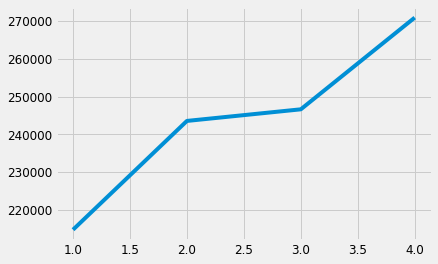

In [39]:
# seasonal transactions
plt.plot(transactions.groupby(['season']).size())

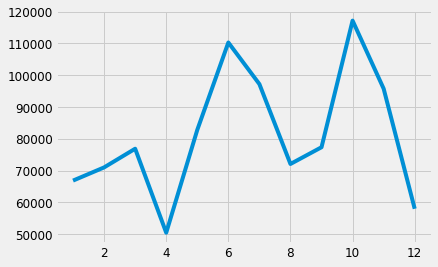

In [40]:
# monthly transactions
plt.plot(transactions.groupby(['month']).size())

<function matplotlib.pyplot.show(close=None, block=None)>

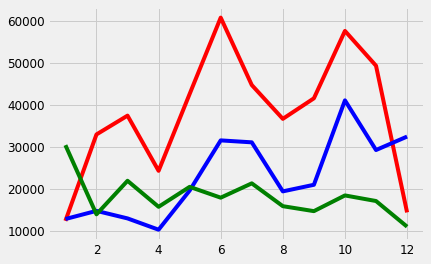

In [41]:
# monthly for each year
plt.plot(transactions[transactions['year'] == 2017].groupby(['month']).size(), color='r')
plt.plot(transactions[transactions['year'] == 2018].groupby(['month']).size(), color='b')
plt.plot(transactions[transactions['year'] == 2019].groupby(['month']).size(), color='g')
# plt.legend()
plt.show